In [352]:
import os
import matplotlib.pyplot as plt
import torch
import numpy as np

from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
from torch.distributions import constraints

from pyro.infer.mcmc import NUTS
from pyro.infer.mcmc import MCMC

import arviz as az
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

assert pyro.__version__.startswith('1.8.6')
torch.set_default_dtype(torch.float32)
torch.set_default_device('cpu')
pyro.set_rng_seed(10)

In [353]:
def plot(
    plot_observed_data=False,
    plot_predictions=False,
    n_prior_samples=0,
    model=None,
    kernel=None,
    n_test=500,
    ax=None,
    plot_test_points=None
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    if plot_observed_data:
        ax.plot(X_train.numpy(), y_train.numpy(), "kx", label="train points")
    if plot_test_points:
        ax.plot(X_test.numpy(), y_test.numpy(), "ko", label="test points")
        plt.legend()
    if plot_predictions:
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        ax.plot(Xtest.numpy(), mean.numpy(), "r", lw=2)  # plot the mean
        ax.fill_between(
            Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="C0",
            alpha=0.3,
        )
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        noise = (
            model.noise
            if type(model) != gp.models.VariationalSparseGP
            else model.likelihood.variance
        )
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(
            torch.zeros(n_test), covariance_matrix=cov
        ).sample(sample_shape=(n_prior_samples,))
        ax.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)
    
    ax.set_xlim(-0.5, 2)

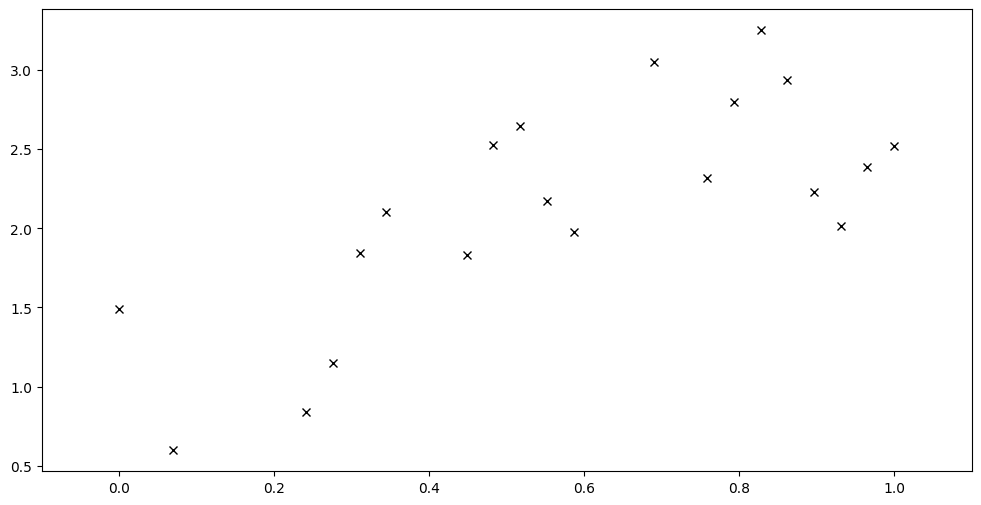

In [354]:
# generate data and plot it
N = 30
X = []
for i in range(1, 31):
    xi = (i - 1)/(30 - 1)
    X.append(xi)

X = torch.tensor(X)
noise = dist.Normal(0.0, 0.01).sample(sample_shape=(N,))
y = -(torch.sin(6 * torch.pi * X))**2 + 6 * X**2 - 5 * X**4 + 3/2 + noise

plot(plot_observed_data=True)  # let's plot the observed data
_ = plt.xlim((-0.1, 1.1))

In [355]:
# split into train and test
indices = torch.randperm(len(X))[:20]
first = torch.arange(0, 30, 1)
diff=first[(first.view(1, -1) != indices.view(-1, 1)).all(dim=0)]

X_train = X[indices]
y_train = y[indices]

X_test = X[diff]
y_test = y[diff]

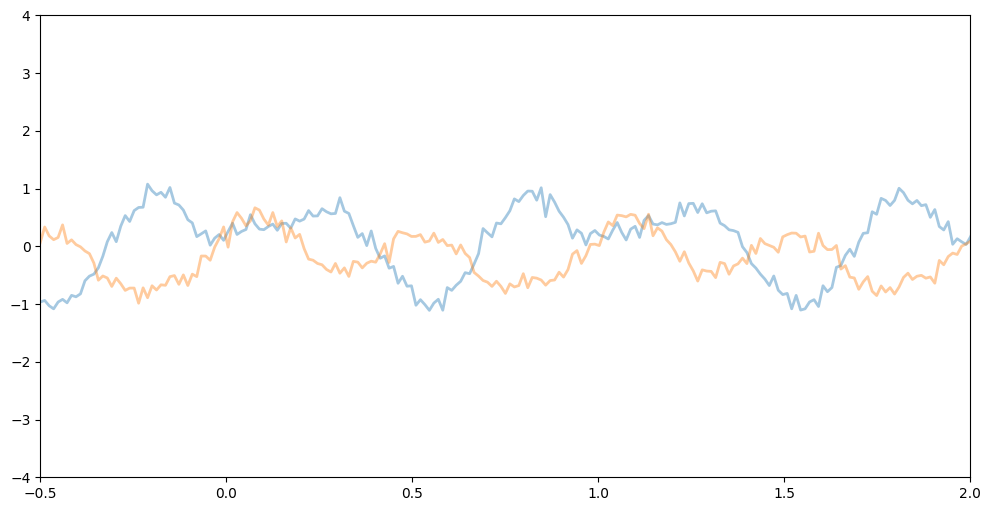

In [356]:
# define kernel with some values
pyro.clear_param_store()
kernel = gp.kernels.Periodic(
    input_dim=1, variance=torch.tensor(1.0),
    lengthscale=torch.tensor(1.0),
    period=torch.tensor(1.0) 
)
gpr = gp.models.GPRegression(X_train, y_train, kernel, noise=torch.tensor(0.01))

# plot to see
plot(model=gpr, kernel=kernel, n_prior_samples=2)
_ = plt.ylim((-4, 4))

In [357]:
# now we perform gradient descent to optimize params
optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
variances = []
lengthscales = []
noises = []
num_steps = 2000
for i in range(num_steps):
    variances.append(gpr.kernel.variance.item())
    noises.append(gpr.noise.item())
    lengthscales.append(gpr.kernel.lengthscale.item())
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

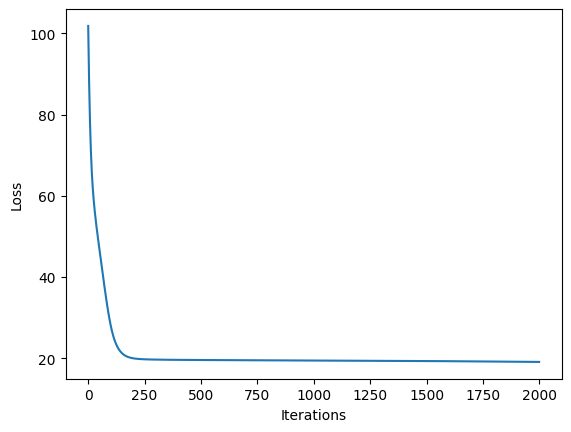

In [358]:
# let's plot the loss curve after 2000 steps of training
def plot_loss(loss):
    plt.plot(loss)
    plt.xlabel("Iterations")
    _ = plt.ylabel("Loss")  # supress output text

plot_loss(losses)

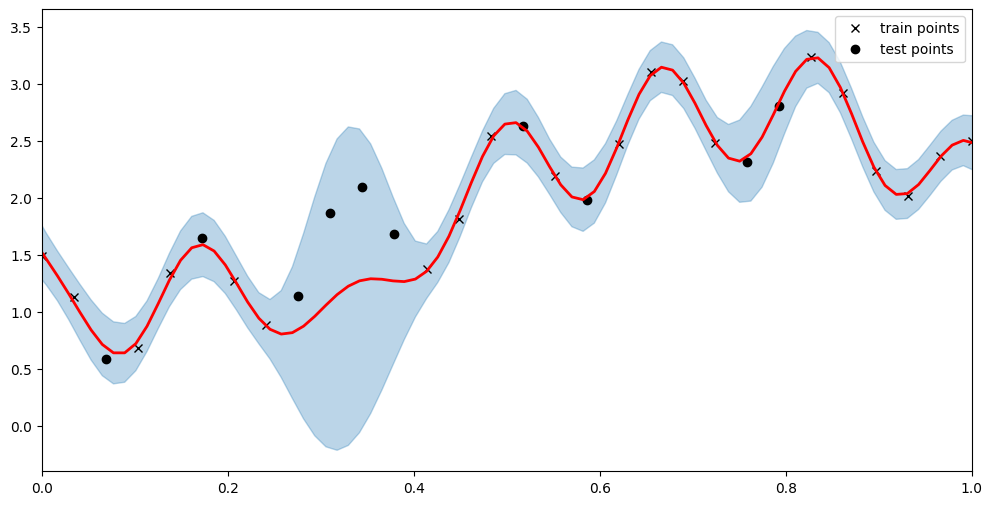

In [359]:
plot(model=gpr, plot_observed_data=True, plot_predictions=True, plot_test_points=True)
_ = plt.xlim(0, 1)

In [360]:
print("variance: ", gpr.kernel.variance.item())
print("length scale: ", gpr.kernel.lengthscale.item())
print("period: ", gpr.kernel.period.item())
print("noise: ", gpr.noise.item())

variance:  3.044954299926758
length scale:  0.4408505856990814
period:  1.0816230773925781
noise:  0.007363681215792894


In [361]:
fig, ax = plt.subplots(figsize=(12, 6))

def update(iteration):
    pyro.clear_param_store()
    ax.cla()
    kernel_iter = gp.kernels.RBF(
        input_dim=1,
        variance=torch.tensor(variances[iteration]),
        lengthscale=torch.tensor(lengthscales[iteration]),
    )
    gpr_iter = gp.models.GPRegression(
        X, y, kernel_iter, noise=torch.tensor(noises[iteration])
    )
    plot(model=gpr_iter, plot_observed_data=True, plot_predictions=True, ax=ax)
    ax.set_title(f"Iteration: {iteration}, Loss: {losses[iteration]:0.2f}")


anim = FuncAnimation(fig, update, frames=np.arange(0, num_steps, 30), interval=100)
plt.close()
anim.save("./source/gpr-fit.gif", fps=60)

MovieWriter ffmpeg unavailable; using Pillow instead.


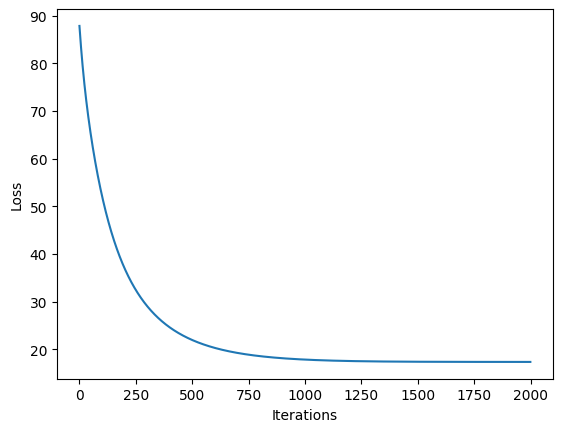

In [362]:
# now lets set some priors
pyro.clear_param_store()

# define model
kernel = gp.kernels.Periodic(
    input_dim=1
)
gpr = gp.models.GPRegression(X_train, y_train, kernel, noise=torch.tensor(0.01))

# set prior mean and variance for each param
mu = 0.0
var = 0.5


# create joint prior distribution
mean = torch.tensor([mu, mu, mu])
covar = torch.diag(torch.tensor([var, var, var]))

prior = dist.MultivariateNormal(loc=mean, covariance_matrix=covar)

# LogNormal
prior = dist.TransformedDistribution(
    dist.MultivariateNormal(loc=mean, covariance_matrix=covar),
    dist.transforms.ExpTransform()
)

# set priors on the kernel
gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(mu, var))
gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(mu, var))
gpr.kernel.period = pyro.nn.PyroSample(dist.LogNormal(mu, var))

# perform gradient descent to optimize parameters
optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
num_steps = 2000
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plot_loss(losses)

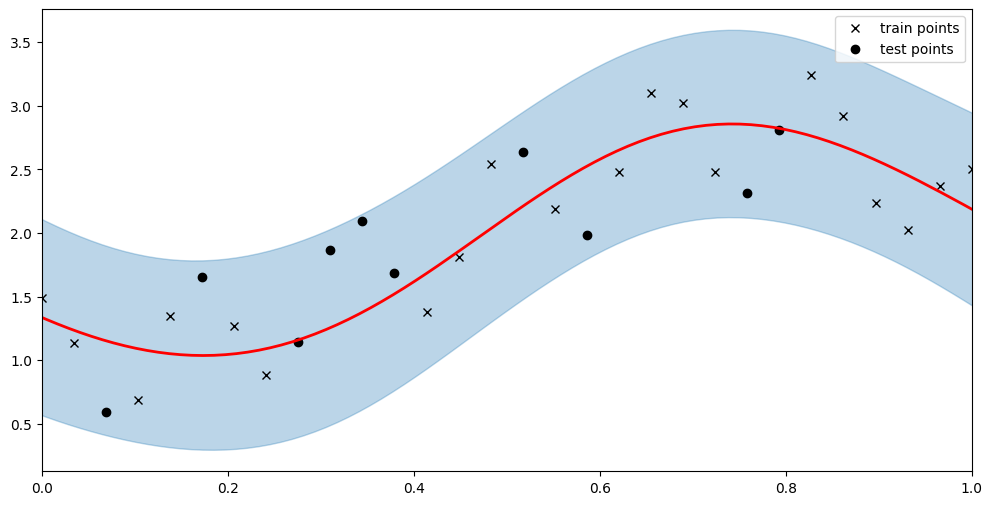

In [363]:
plot(model=gpr, plot_observed_data=True, plot_predictions=True, plot_test_points=True)
_ = plt.xlim(0, 1)

In [364]:
gpr.set_mode("guide")
print("variance = {}".format(gpr.kernel.variance))
print("lengthscale = {}".format(gpr.kernel.lengthscale))
print("period = {}".format(gpr.kernel.period))
print("noise = {}".format(gpr.noise))

variance = 1.1355416774749756
lengthscale = 1.658137559890747
period = 1.2209503650665283
noise = 0.11262841522693634


In [365]:
def logLikelihood(params, gpr, X, y, prior):
    l = y.shape[0]
    noise_y = gpr.noise
    K = gpr.kernel(X, X)
    sigma_y_I = noise_y * torch.eye(l)
    inverse = torch.linalg.inv((sigma_y_I + K))
    det = torch.linalg.det((sigma_y_I + K))
    sqrt = torch.sqrt(2 * torch.pi)

    evidence_ll = -0.5 * (y.T @ inverse @ y + torch.log(det) + l * torch.log(sqrt))
    prior_prob = prior.log_prob(params)

    return prior_prob + evidence_ll

In [366]:
# sample using NUTS
n_samples = 500
n_chains = 2
n_warmup = 100

pyro.clear_param_store()
# compute second moment quantity
nuts_kernel = pyro.infer.NUTS(gpr.model, jit_compile=True)
mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=n_samples,
                       num_chains=n_chains)
mcmc.run()

Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

/Users/madsfrandsen/Documents/MLA/venv/lib/python3.9/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/madsfrandsen/Documents/MLA/venv/lib/python3.9/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/madsfrandsen/Documents/MLA/venv/lib/python3.9/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can'

/Users/madsfrandsen/Documents/MLA/venv/lib/python3.9/site-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(



                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel.lengthscale      1.63      0.53      1.56      0.72      2.38    215.30      1.01
       kernel.period      1.60      0.50      1.45      1.01      2.22    211.50      1.02
     kernel.variance      1.56      0.61      1.44      0.70      2.52    553.74      1.00

Number of divergences: 0
None


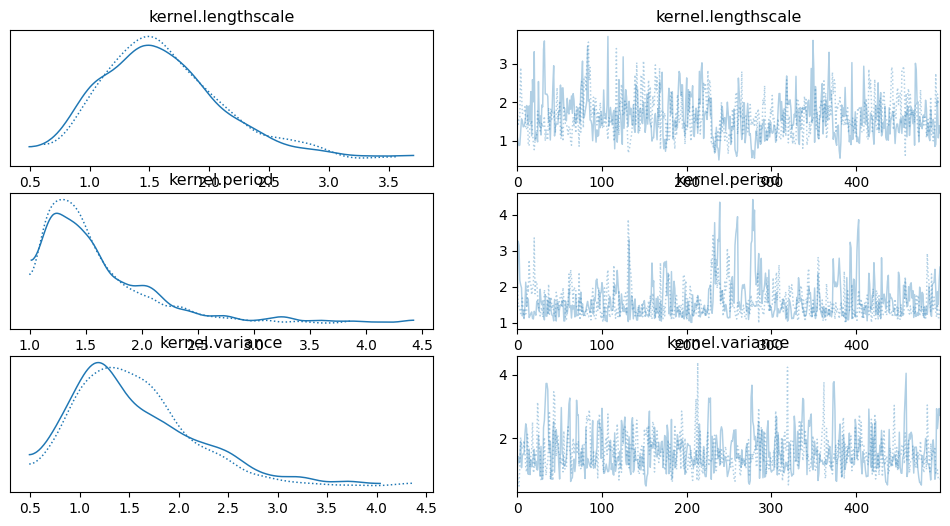

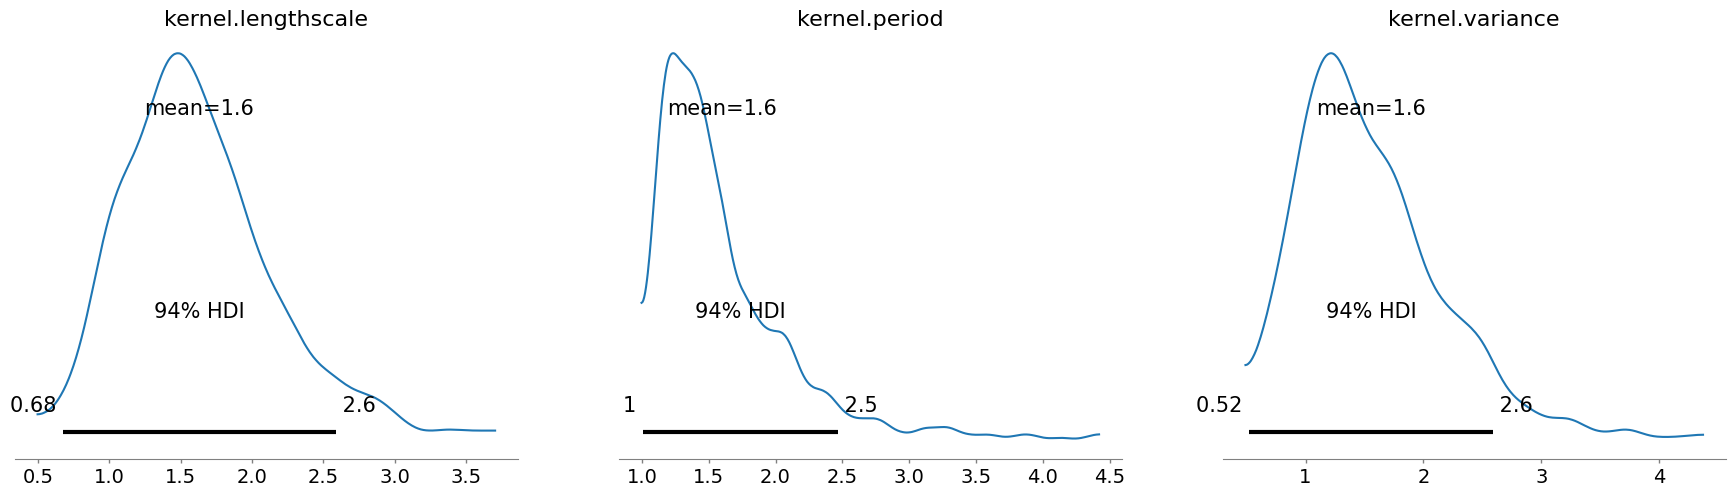

In [373]:
# inspect posterior
samples = mcmc.get_samples()
sample_data = az.from_pyro(mcmc)
sample_summary = az.summary(sample_data)


print(mcmc.summary())
az.plot_trace(sample_data)
plt.show()
az.plot_posterior(sample_data)
plt.show()